In [1]:
import os
import json
import nltk
import string
import shutil
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pprint import pprint
from termcolor import colored
from collections import Counter
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from typing import Dict, List, Counter as CounterType

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dever\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dever\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dever\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def get_document_ids(directory: str) -> List[str]:
    """
    Extracts unique document identifiers from filenames within a given directory.
    
    Args:
        directory (str): The path to the directory containing the files.
    
    Returns:
        List[str]: A list of unique document identifiers.
    
    Raises:
        OSError: If the specified directory does not exist.
        ValueError: If no files match the expected naming convention.
    """
    if not os.path.exists(directory):
        raise OSError(f"Directory {directory} does not exist.")
    
    doc_ids = list()
    for filename in os.listdir(directory):
        doc_id = filename.split(".")[0]  # Extract the doc ID from the filename
        if doc_id and doc_id not in doc_ids:
            doc_ids.append(doc_id)  # Adding the doc ID if it's unique and not empty
    
    if not doc_ids:
        raise ValueError(f"No files with expected naming convention found in {directory}.")
    
    return doc_ids

data_directory = os.path.join("..", "dataset")
document_ids = get_document_ids(data_directory)
pprint(document_ids)

['15939911',
 '16778410',
 '17803823',
 '18236639',
 '18258107',
 '18416479',
 '18561524',
 '18666334',
 '18787726',
 '18815636',
 '19009665',
 '19214295',
 '19307547',
 '19610147',
 '19816630',
 '19860006',
 '19860007',
 '19860925',
 '20146086',
 '20671919',
 '20977862',
 '21067996',
 '21129213',
 '21254744',
 '21308977',
 '21477357',
 '21505579',
 '21527041',
 '21672201',
 '21720478',
 '21923918',
 '22218279',
 '22514576',
 '22515939',
 '22520024',
 '22665582',
 '22719160',
 '22781096',
 '22791498',
 '22814979',
 '23033875',
 '23035161',
 '23076693',
 '23077697',
 '23124805',
 '23155491',
 '23242090',
 '23312850',
 '23468586',
 '23678274',
 '23864579',
 '23897372',
 '24043987',
 '24161539',
 '24294397',
 '24518095',
 '24526194',
 '24654246',
 '24781756',
 '24898994',
 '24957905',
 '25023062',
 '25024632',
 '25139918',
 '25155594',
 '25210224',
 '25246819',
 '25293719',
 '25295501',
 '25370695',
 '25410034',
 '25410883',
 '25572898',
 '25661749',
 '25721834',
 '25743872',
 '25759562',

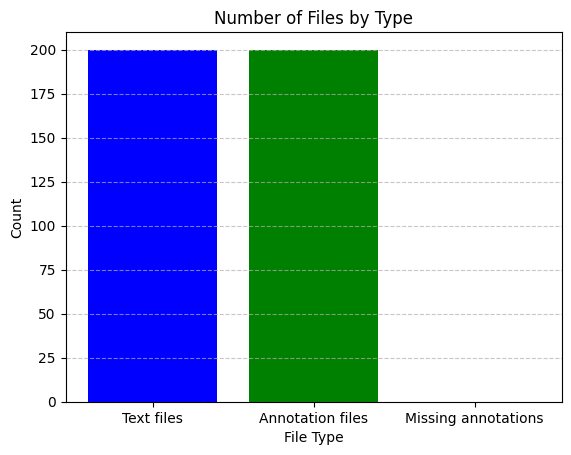

In [4]:
def plot_file_statistics(directory: str) -> None:
    """
    Plots a bar chart of text files, annotation files, and text files missing annotations in a directory.
    
    Args:
        directory (str): The path to the directory containing the text and annotation files.
    """
    # Listing text and annotation files based on their extensions
    text_files = [file_name for file_name in os.listdir(directory) if file_name.endswith('.txt')]
    ann_files = [file_name for file_name in os.listdir(directory) if file_name.endswith('.ann')]
    
    # Extracting identifiers from file names
    text_ids = [file_name.split('.')[0] for file_name in text_files]
    annotated_ids = [file_name.split('.')[0] for file_name in ann_files]

    # Count the number of text files without corresponding annotation files
    missing_annotations = sum(1 for text_id in text_ids if text_id not in annotated_ids)

    # Data for plot
    labels = ['Text files', 'Annotation files', 'Missing annotations']
    counts = [len(text_files), len(ann_files), missing_annotations]

    # Plotting the bar chart
    plt.bar(labels, counts, color=['blue', 'green', 'red']) 
    plt.title('Number of Files by Type')
    plt.xlabel('File Type')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding grid lines
    plt.show()

data_directory = os.path.join("..", "dataset")
plot_file_statistics(data_directory)


In [5]:
def load_text_data(text_directory: str, document_ids: List[str]) -> Dict[str, Dict[str, List[str]]]:
    """
    Loads text data from .txt files located in a specified directory based on a list of document identifiers.
    
    Args:
        text_directory (str): The directory where the .txt files are stored.
        document_ids (List[str]): A list of document identifiers without the file extension.
    
    Returns:
        Dict[str, Dict[str, List[str]]]: A dictionary mapping each document identifier to its text content
            and an empty list of annotations.
    
    Raises:
        OSError: If the specified directory does not exist.
        ValueError: If no .txt files are found for the provided document identifiers.
    """
    # Check if the directory exists
    if not os.path.exists(text_directory):
        raise OSError(f"Directory {text_directory} does not exist.")

    data = dict()
    
    # Load text data for each document identifier
    for doc_id in document_ids:
        file_path = os.path.join(text_directory, doc_id + ".txt")  # Complete path to the text file
        
        try:
            with open(file_path, "r", encoding='utf-8') as file:
                text_content = file.read()
                data[doc_id] = {
                    "text": text_content, 
                    "annotations": []
                }
        except FileNotFoundError:
            continue  # Skip files that are not found
    
    if not data:
        raise ValueError(f"No .txt files found in {text_directory} for the provided IDs.")

    return data

In [6]:
data = load_text_data(data_directory, document_ids)

print("data: {")
# Looping through the first three document IDs or fewer if there are not enough documents
for doc_id in list(data.keys())[:3]:
    print(f"\t'{doc_id}': {{")
    text = data[doc_id]['text']
    annotations = data[doc_id]['annotations']
    # Display a preview of the text, limiting to the first 78 characters, followed by an ellipsis if longer
    print(f"\t\ttext: '{text[:78]}...'")
    print(f"\t\tannotations: {annotations}")
    print("\t},")
# Indicate continuation if there are more documents
if len(data.keys()) > 3:
    print("\t....")
print("}")


data: {
	'15939911': {
		text: 'CASE: A 28-year-old previously healthy man presented with a 6-week history of ...'
		annotations: []
	},
	'16778410': {
		text: 'The patient was a 34-yr-old man who presented with complaints of fever and a c...'
		annotations: []
	},
	'17803823': {
		text: 'A 23 year old white male with a 4 year history of Crohn's disease presented wi...'
		annotations: []
	},
	....
}


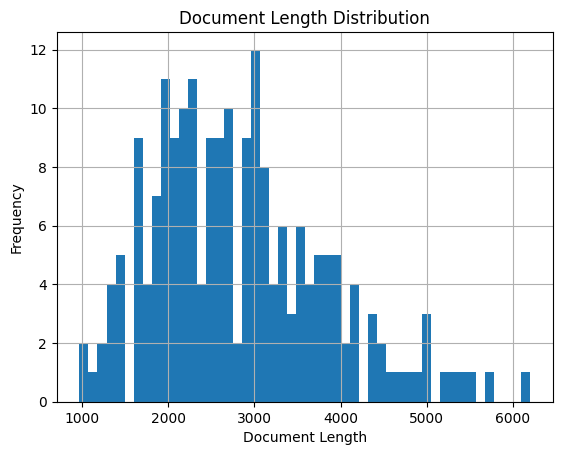

In [7]:
def get_document_length_distribution(data: Dict[str, Dict[str, str]]) -> List[int]:
    """
    Computes the lengths of documents from a dictionary of data where each document's text is stored under a 'text' key.
    
    Args:
        data (Dict[str, Dict[str, str]]): Dictionary containing document data, where each key is a document ID and the value is another dictionary, which includes a 'text' key containing the document text.
    
    Returns:
        List[int]: A list containing the lengths of each document.
    """
    doc_lengths = list()
    for doc_id in data:
        text = data[doc_id]['text']  # Retrieve the text of the document
        doc_length = len(text)  # Calculate the length of the text
        doc_lengths.append(doc_length)  # Append the length to the list
    
    return doc_lengths

doc_lengths = get_document_length_distribution(data)

# Plotting the document length distribution
plt.hist(doc_lengths, bins=50)  # Histogram with 50 bins
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.title("Document Length Distribution")
plt.grid(True)
plt.show()


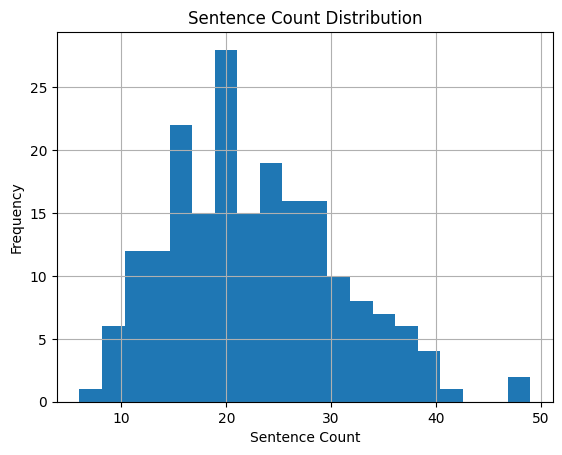

In [8]:
def get_document_sentence_counts(data: Dict[str, Dict[str, str]]) -> List[int]:
    """
    Computes the number of sentences in each document based on the document data provided.

    Args:
        data (Dict[str, Dict[str, str]]): Dictionary containing document data, 
            where each key is a document ID and the value includes a 'text' key containing the document text.

    Returns:
        List[int]: A list containing the sentence count distribution.
    """
    # Initialize list to store sentence counts
    sentence_counts = list()
    for doc_id in data:
        text = data[doc_id]['text']
        sentences = nltk.sent_tokenize(text)  # Tokenize the text into sentences
        sentence_count = len(sentences)
        sentence_counts.append(sentence_count)  # Append the count to the list

    return sentence_counts

sentence_counts = get_document_sentence_counts(data)

plt.hist(sentence_counts, bins=20) # Histogram with 20 bins
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.title("Sentence Count Distribution")
plt.grid(True)
plt.show()

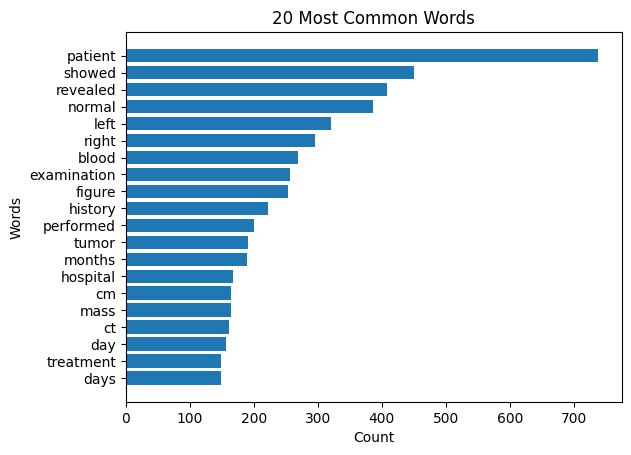

In [9]:
stop_words = set(stopwords.words('english'))

def get_most_common_words(data, num_words=20):
    """
    Extracts the most common words from a collection of documents, excluding stopwords.
    
    Args:
        data (dict): A dictionary containing document IDs as keys and dictionaries with 'text' keys as values.
        num_words (int): The number of most common words to retrieve.

    Returns:
        list: A list of tuples where each tuple contains a word and its frequency.
    """
    all_words = list()

    # Tokenize words in each document and filter out non-alphabetic words and stopwords
    for doc_id in data:
        text = data[doc_id]['text']
        words = nltk.word_tokenize(text)
        filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
        all_words.extend(filtered_words)

    # Gets the word frequency distribution
    word_freq = Counter(all_words)

    # Gets the most common words
    most_common = word_freq.most_common(num_words)
    return most_common

most_common_words = get_most_common_words(data)

words, counts = zip(*most_common_words)

plt.barh(words, counts)
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("20 Most Common Words")
plt.gca().invert_yaxis()
plt.show()

In [10]:
def read_annotation_preview(data_directory: str, document_id: str, num_lines: int = 6) -> None:
    """
    Reads an annotation file for a given document ID and prints a preview of the first few lines.
    
    Args:
        data_directory (str): The directory where the annotation files are stored.
        document_id (str): The ID of the document for which the annotation file is read.
        num_lines (int): Number of lines to preview from the annotation file.
    """
    sample_ann_file = document_id + ".ann"
    lines = list()

    # Constructing the full path for the annotation file
    file_path = os.path.join(data_directory, sample_ann_file)

    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return

    print("")  # Print a newline for better separation in output
    for line in lines[:num_lines]:
        print(line.strip())

data_directory = os.path.join("..", "dataset") 
document_id = doc_id
read_annotation_preview(data_directory, document_id)


T1	Age 2 13	23 year old
T2	Personal_background 14 19	white
T3	Sex 20 24	male
T4	History 32 65	4 year history of Crohn's disease
T5	Disease_disorder 50 65	Crohn's disease
E1	Disease_disorder:T5


In [11]:
def extract_unique_tags(data_directory: str, document_ids: list) -> set:
    """
    Extracts and returns a set of unique first characters from the first field of each line in the annotation files.
    
    Args:
        data_directory (str): The directory where the annotation files are stored.
        document_ids (list): A list of document IDs whose annotation files will be read.
    
    Returns:
        set: A set of unique first characters from the first field of lines in the annotation files.
    """
    tags = list()

    for doc_id in document_ids:
        ann_file = f"{doc_id}.ann"
        file_path = os.path.join(data_directory, ann_file)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file.readlines():
                    if line.strip():  # Ensure that the line is not empty
                        tags.append(line.split("\t")[0][0])
        except FileNotFoundError:
            if  doc_id == "annotated_data":
                continue
            print(f"Warning: Annotation file not found for document ID {doc_id}.")
        except Exception as e:
            print(f"Error processing file {ann_file}: {e}")
    
    return set(tags)

data_directory = os.path.join("..", "dataset")  
unique_tags = extract_unique_tags(data_directory, document_ids)
pprint(unique_tags)


{'T', 'E', 'A', '*', 'R', '#'}


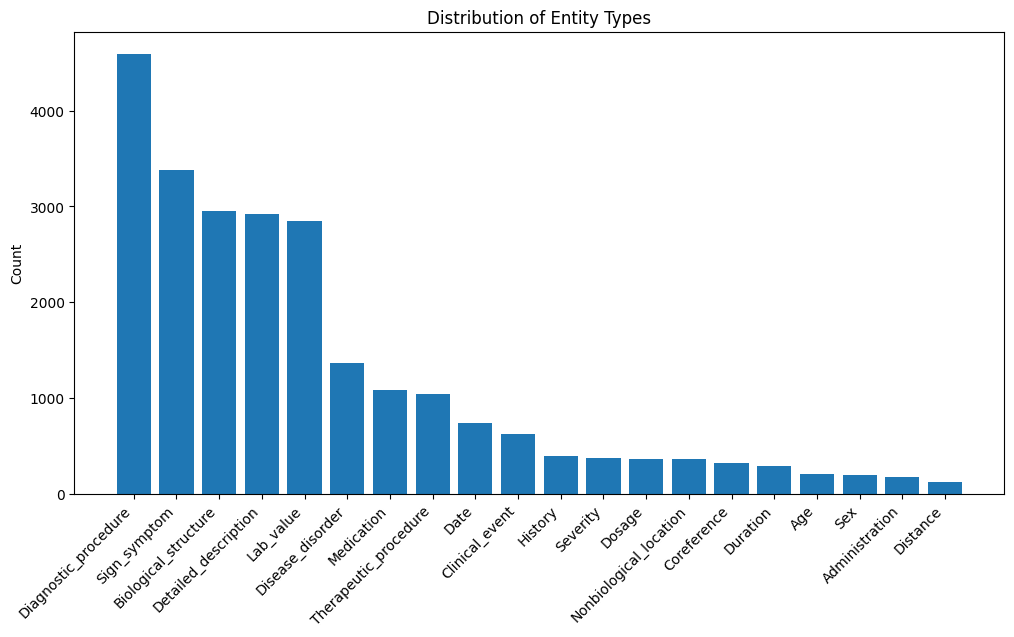

In [12]:
def count_entity_types(data_directory: str, document_ids: list) -> dict:
    """
    Counts occurrences of each entity type in annotation files for a list of document IDs.

    Args:
        data_directory (str): The directory where the annotation files are stored.
        document_ids (list): A list of document IDs whose annotation files will be read.
    
    Returns:
        dict: A dictionary with entity types as keys and their respective counts as values.
    """
    entity_type_counts = dict()

    for doc_id in document_ids:
        ann_file = f"{doc_id}.ann"
        file_path = os.path.join(data_directory, ann_file)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    if line.startswith("T"):
                        entity_type = line.split()[1]
                        entity_type_counts[entity_type] = entity_type_counts.get(entity_type, 0) + 1
        except FileNotFoundError:
            if  doc_id == "annotated_data":
                continue
            print(f"Warning: Annotation file not found for document ID {doc_id}.")
        except Exception as e:
            print(f"Error processing file {ann_file}: {e}")
    
    return entity_type_counts

def plot_entity_distribution(entity_counts: dict, top_n: int = 20):
    """
    Plots a bar chart of the most common entity types sorted by count.

    Args:
        entity_counts (dict): Dictionary with entity types as keys and counts as values.
        top_n (int): The number of top entities to display.
    """
    # Sorting the entity types by count in descending order
    entity_types_sorted = sorted(entity_counts.items(), key=lambda item: item[1], reverse=True)[:top_n]
    entity_types, counts = zip(*entity_types_sorted)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(entity_types, counts)
    ax.set_xticks(range(len(entity_types)))
    ax.set_xticklabels(entity_types, rotation=45, ha="right")
    ax.set_ylabel("Count")
    ax.set_title("Distribution of Entity Types")
    plt.show()

data_directory = os.path.join("..", "dataset")
entity_type_counts = count_entity_types(data_directory, document_ids)
plot_entity_distribution(entity_type_counts)

In [13]:
def split_tokens(doc_id: str, start: int, end: int, text: str, hyphen_split: bool = True) -> list:
    """
    Splits a substring from the document's text into tokens based on hyphens and updates their indices.
    
    Args:
        doc_id (str): Document identifier.
        start (int): Start index of the annotation in the document text.
        end (int): End index of the annotation in the document text.
        text (str): Complete text of the document.
        hyphen_split (bool): Flag to determine if splitting by hyphen is required.

    Returns:
        list of tuples: Each tuple contains a token and its corresponding start and end indices within the document text.
    """
    # Extract the substring from the document's text based on the provided start and end indices
    substring = text[start:end]

    # If hyphen splitting is enabled, split the substring into parts and calculate their new indices
    if hyphen_split:
        parts = substring.split('-')
        tokens_with_indices = list()
        offset = 0  # Initial offset from the start index

        for part in parts:
            part_start = start + offset
            part_end = part_start + len(part)
            tokens_with_indices.append((part, part_start, part_end))
            offset += len(part) + 1  # Move offset past the end of the current part and the hyphen

        return tokens_with_indices
    else:
        # If hyphen splitting is not enabled, return the original substring with its indices
        return [(substring, start, end)]

In [14]:
def load_ann_data(ann_dir: str, doc_ids: list, data: dict, hyphen_split: bool = True) -> dict:
    """
    Loads and processes annotations from files for given document IDs, updating a data dictionary with annotations.
    
    Args:
        ann_dir (str): Directory where the annotation files are stored.
        doc_ids (list): List of document identifiers whose annotation files will be processed.
        data (dict): Data dictionary where text and annotations are stored.
        hyphen_split (bool): Flag to determine if hyphen-splitting of tokens is necessary.
    
    Returns:
        dict: Updated data dictionary containing text and processed annotations for each document.
    """
    for doc_id in doc_ids:
        file_name = f"{doc_id}.ann"
        file_path = os.path.join(ann_dir, file_name)

        try:
            with open(file_path, "r", encoding='utf-8') as f:
                annotations = []

                for line in f:
                    if line.startswith("T"):
                        fields = line.strip().split("\t")
                        if len(fields) > 1 and len(fields[1].split()) > 1:
                            label = fields[1].split()[0]
                            position_data = fields[1].split()[1:]

                            # Handling disjoint ranges of annotations
                            start_end_range = [
                                list(map(int, pos.split()))
                                for pos in ' '.join(position_data).split(';')
                            ]

                            for start, end in start_end_range:
                                tokens_with_indices = split_tokens(doc_id, start, end, data[doc_id]['text'], hyphen_split)

                                for token, new_start, new_end in tokens_with_indices:
                                    annotations.append({
                                        "label": label,
                                        "token": token,
                                        "start": new_start,
                                        "end": new_end
                                    })
                
                # Sorting annotations by start index (and label for consistency in cases of same start index)
                annotations = sorted(annotations, key=lambda x: (x['start'], x['label']))
                data[doc_id]["annotations"] = annotations

        except FileNotFoundError:
            if  doc_id == "annotated_data":
                continue
            print(f"Warning: Annotation file not found for document ID {doc_id}. Continuing to next document.")
        except Exception as e:
            print(f"Error reading or processing annotation file {file_name}: {e}")

    return data

data = load_ann_data(data_directory, document_ids, data)

In [15]:
for doc_id in list(data.keys())[:3]:
    text = data[doc_id]['text']
    annotations = data[doc_id]['annotations']

    # Print a preview of the document's text (first 40 characters)
    print(f"Document ID: {doc_id}")
    print(f"Text Preview: {text[:40]}...")
    print("Annotations Preview:")
    
    # Print a preview of the first two annotations for the document
    for annotation in annotations[:2]:
        print(f" - Label: {annotation['label']}, Token: {annotation['token']}, "
              f"Start: {annotation['start']}, End: {annotation['end']}")

    print(".....\n")


Document ID: 15939911
Text Preview: CASE: A 28-year-old previously healthy m...
Annotations Preview:
 - Label: Age, Token: 28, Start: 8, End: 10
 - Label: Age, Token: year, Start: 11, End: 15
.....

Document ID: 16778410
Text Preview: The patient was a 34-yr-old man who pres...
Annotations Preview:
 - Label: Age, Token: 34, Start: 18, End: 20
 - Label: Age, Token: yr, Start: 21, End: 23
.....

Document ID: 17803823
Text Preview: A 23 year old white male with a 4 year h...
Annotations Preview:
 - Label: Age, Token: 23 year old, Start: 2, End: 13
 - Label: Personal_background, Token: white, Start: 14, End: 19
.....



In [16]:
entities = set()

# Iterate over each document in the data dictionary
for doc_id, doc_data in data.items():
    for annotation in doc_data['annotations']:
        entities.add(annotation['label'])

for entity in sorted(entities):
    print(entity)

Activity
Administration
Age
Area
Biological_attribute
Biological_structure
Clinical_event
Color
Coreference
Date
Detailed_description
Diagnostic_procedure
Disease_disorder
Distance
Dosage
Duration
Family_history
Frequency
Height
History
Lab_value
Mass
Medication
Nonbiological_location
Occupation
Other_entity
Other_event
Outcome
Personal_background
Qualitative_concept
Quantitative_concept
Severity
Sex
Shape
Sign_symptom
Subject
Texture
Therapeutic_procedure
Time
Volume
Weight


In [17]:
colors = {
    "Activity": "#123456", 
    "Administration": "#789abc", 
    "Age": "#def123", 
    "Area": "#456789", 
    "Biological_attribute": "#abc456", 
    "Biological_structure": "#123def", 
    "Clinical_event": "#456abc", 
    "Color": "#789def", 
    "Coreference": "#abc123", 
    "Date": "#def789",
    "Detailed_description": "#234567", 
    "Diagnostic_procedure": "#890abc", 
    "Disease_disorder": "#567890", 
    "Distance": "#abc234", 
    "Dosage": "#234def", 
    "Duration": "#890456", 
    "Family_history": "#567def", 
    "Frequency": "#234789", 
    "Height": "#890def", 
    "History": "#567123",
    "Lab_value": "#890123", 
    "Mass": "#567234", 
    "Medication": "#123456", 
    "Nonbiological_location": "#789abc", 
    "Occupation": "#def123", 
    "Other_entity": "#abc456", 
    "Other_event": "#123def", 
    "Outcome": "#456abc", 
    "Personal_background": "#789def", 
    "Qualitative_concept": "#abc123",
    "Quantitative_concept": "#def789", 
    "Severity": "#234567", 
    "Sex": "#890abc", 
    "Shape": "#567890", 
    "Sign_symptom": "#abc234", 
    "Subject": "#234def", 
    "Texture": "#890456", 
    "Therapeutic_procedure": "#567def", 
    "Time": "#234789", 
    "Volume": "#890def", 
    "Weight": "#567123"
}

In [18]:
def validate_colors(color_dict):
    import re
    hex_color_pattern = re.compile("^#(?:[0-9a-fA-F]{3}){1,2}$")
    
    invalid_colors = {k: v for k, v in color_dict.items() if not hex_color_pattern.match(v)}
    if invalid_colors:
        print("Invalid color codes found:", invalid_colors)
    else:
        print("All color codes are valid.")

    # Check for duplicate color values
    color_values = list(color_dict.values())
    if len(color_values) != len(set(color_values)):
        print("Duplicate color values found.")
    else:
        print("All color values are unique.")

validate_colors(colors)

All color codes are valid.
Duplicate color values found.


In [19]:
def print_colored_text(text, annotations):

    last_end = 0
    result = ""
    
    for ann in sorted(annotations, key=lambda x: x['start']):
        start, end, label = ann['start'], ann['end'], ann['label']
        if start > last_end:
            result += text[last_end:start]
        result += colored(text[start:end], 'white', 'on_grey', attrs=['bold'])
        last_end = end
    
    result += text[last_end:]  # Append any remaining text after the last annotation
    print(result)

# Example text and annotations
text = "John has been diagnosed with Type 2 Diabetes and prescribed Metformin."
annotations = [{'start': 29, 'end': 45, 'label': 'Disease_disorder'}, {'start': 60, 'end': 69, 'label': 'Medication'}]

print_colored_text(text, annotations)

John has been diagnosed with Type 2 Diabetes and prescribed Metformin.


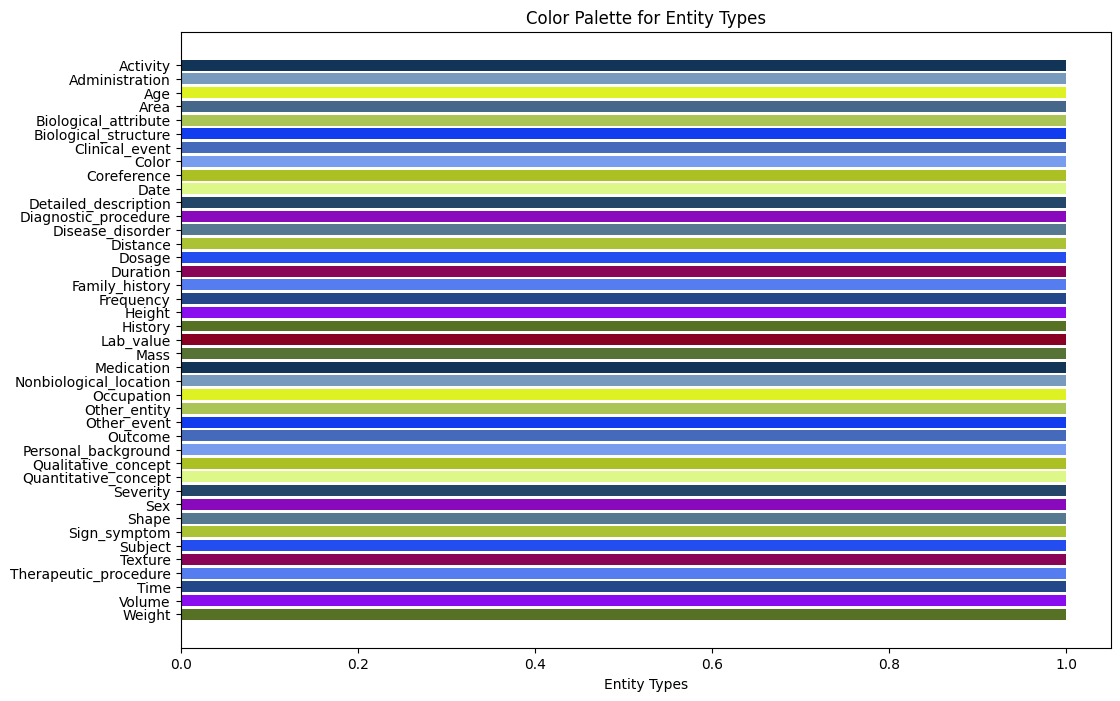

In [20]:
def display_color_palette(color_dict):
    # Display all colors in the dictionary
    labels = list(color_dict.keys())
    colors = list(color_dict.values())
    
    plt.figure(figsize=(12, 8))
    plt.barh(labels, [1]*len(labels), color=colors)
    plt.xlabel('Entity Types')
    plt.title('Color Palette for Entity Types')
    plt.gca().invert_yaxis()
    plt.show()

display_color_palette(colors)

In [21]:
def get_token_counts(data: Dict[str, dict], remove_stop_words: bool = True) -> CounterType[str]:
    """
    Get token counts from annotated text data.

    Args:
        data (Dict[str, dict]): A dictionary where keys are file IDs and values are dictionaries containing 'text' and 'annotations'.
        remove_stop_words (bool, optional): Flag to remove stop words from tokens. Defaults to True.

    Returns:
        Counter[str]: A Counter object containing token counts.
    """
    # Initialize a Counter object to store token counts
    token_counts = Counter()

    # Get stop words if removal is requested
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))

    # Iterate over each file in the data dictionary
    for file_id, file_data in data.items():
        # Extract text and annotations for the file
        text = file_data['text']
        annotations = file_data['annotations']
        
        # Iterate over annotations in the file
        for annotation in annotations:
            # Extract label, start, and end indices of the annotation
            label = annotation['label']
            start = annotation['start']
            end = annotation['end']
            
            # Extract annotated text based on start and end indices
            annotated_text = text[start:end]
            
            # Split annotated text into tokens
            annotated_tokens = annotated_text.split()
            
            if remove_stop_words:
                annotated_tokens = [token for token in annotated_tokens if token.lower() not in stop_words]
            
            token_counts.update(annotated_tokens)
    
    return token_counts

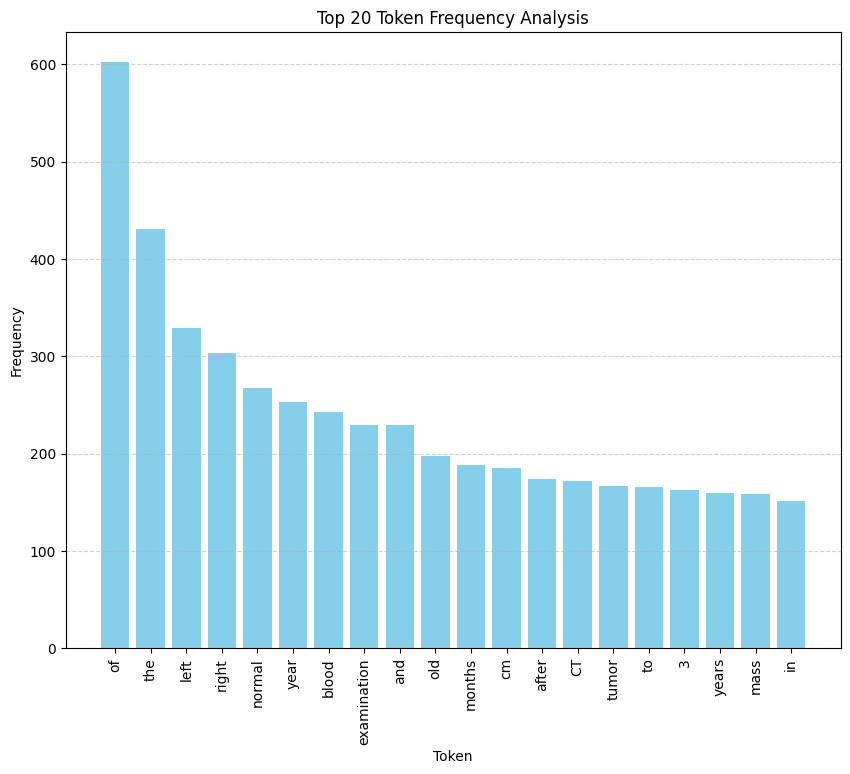

In [22]:
token_counts = get_token_counts(data, remove_stop_words=False)

# Sort the tokens by frequency and get the top 20
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
top_tokens = [t[0] for t in sorted_tokens[:20]]
top_counts = [t[1] for t in sorted_tokens[:20]]

# Creating a bar plot for the top 20 most common tokens
plt.figure(figsize=(10, 8))  # Adjusting the plot size
plt.bar(top_tokens, top_counts, color='skyblue')  
plt.xticks(rotation=90)  # Rotate the x-axis labels
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 20 Token Frequency Analysis')
plt.grid(True, axis='y', linestyle='--', alpha=0.6) 
plt.show()

In [23]:
def create_json(preprocessed_data_dir: str, data: dict):
    """
    Writes the provided data dictionary to a JSON file in a specified directory.
    If the directory exists, its contents are cleared before writing the new data.

    Args:
        preprocessed_data_dir (str): The directory path where the JSON file will be saved.
        data (dict): The data to be written into the JSON file.
    """
    # Ensure the directory is empty and ready to use
    if os.path.exists(preprocessed_data_dir):
        print("Found the data successfully")  # Remove the directory along with all its contents

    # Define the path for the new JSON file
    json_file_path = os.path.join("..", "annotated_data.json")

    # Write the dictionary to a JSON file
    with open(json_file_path, "w") as f:
        json.dump(data, f, indent=4)  # Use indent for pretty printing

preprocessed_data_dir = os.path.join("..", "annotated_dict")
create_json(preprocessed_data_dir, data)

Found the data successfully
